<a href="https://colab.research.google.com/github/RawaaBOUALI/Feature-extraction-for-facial-emotion-recognition/blob/main/Feature_extraction_for_facial_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook contains several feature extraction techniques which are used to extract features from the facial images and then passed to a CNN model to compare their results.**

## Download Data from kaggle

In [9]:
import os

# Configure kaggle
os.chdir('/root/')
!mkdir -p .kaggle
os.chdir('/root/.kaggle')
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Y-o0TVcjehM8SZB3Nt8U3xkyeQu-Nse-' -O kaggle.json > /dev/null 2>&1
!ls /root/.kaggle

# Set permissions 
!chmod 600 /root/.kaggle/kaggle.json

# Create data folder
os.chdir('/content/')
!rm -rf data
!mkdir data
os.chdir('data')
!pwd

# Download data
!pip install -q kaggle
!kaggle datasets download -d shawon10/ckplus

# Unzip data
!unzip *.zip 

kaggle.json
/content/data
 83% 3.00M/3.63M [00:01<00:00, 2.91MB/s]
100% 3.63M/3.63M [00:01<00:00, 2.63MB/s]
Archive:  ckplus.zip
  inflating: CK+48/anger/S010_004_00000017.png  
  inflating: CK+48/anger/S010_004_00000018.png  
  inflating: CK+48/anger/S010_004_00000019.png  
  inflating: CK+48/anger/S011_004_00000019.png  
  inflating: CK+48/anger/S011_004_00000020.png  
  inflating: CK+48/anger/S011_004_00000021.png  
  inflating: CK+48/anger/S014_003_00000028.png  
  inflating: CK+48/anger/S014_003_00000029.png  
  inflating: CK+48/anger/S014_003_00000030.png  
  inflating: CK+48/anger/S022_005_00000030.png  
  inflating: CK+48/anger/S022_005_00000031.png  
  inflating: CK+48/anger/S022_005_00000032.png  
  inflating: CK+48/anger/S026_003_00000013.png  
  inflating: CK+48/anger/S026_003_00000014.png  
  inflating: CK+48/anger/S026_003_00000015.png  
  inflating: CK+48/anger/S028_001_00000022.png  
  inflating: CK+48/anger/S028_001_00000023.png  
  inflating: CK+48/anger/S028_001_0000

## Imports

In [10]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from tensorflow.keras import regularizers
np.random.seed(42)

## Loading data

In [18]:
DATADIR = r'../data/CK+48'

In [19]:
CATEGORIES = os.listdir(DATADIR)
CATEGORIES

['happy', 'surprise', 'contempt', 'anger', 'fear', 'sadness', 'disgust']

In [20]:
def load_data():
    DATADIR = r'../data/CK+48'
    data = []
    # loading training data
    for category in CATEGORIES:
        # create path to image of respective expression
        path = os.path.join(DATADIR, category)
        # get the classification  for each expression 
        class_num = CATEGORIES.index(category)

        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path, img), 0)
            data.append([img_array, class_num])
            
    return data

In [21]:
data = load_data()

100%|██████████| 177/177 [00:00<00:00, 13138.52it/s]


In [113]:
# Size of the dataset
len(data)

981

## Visualization of some images

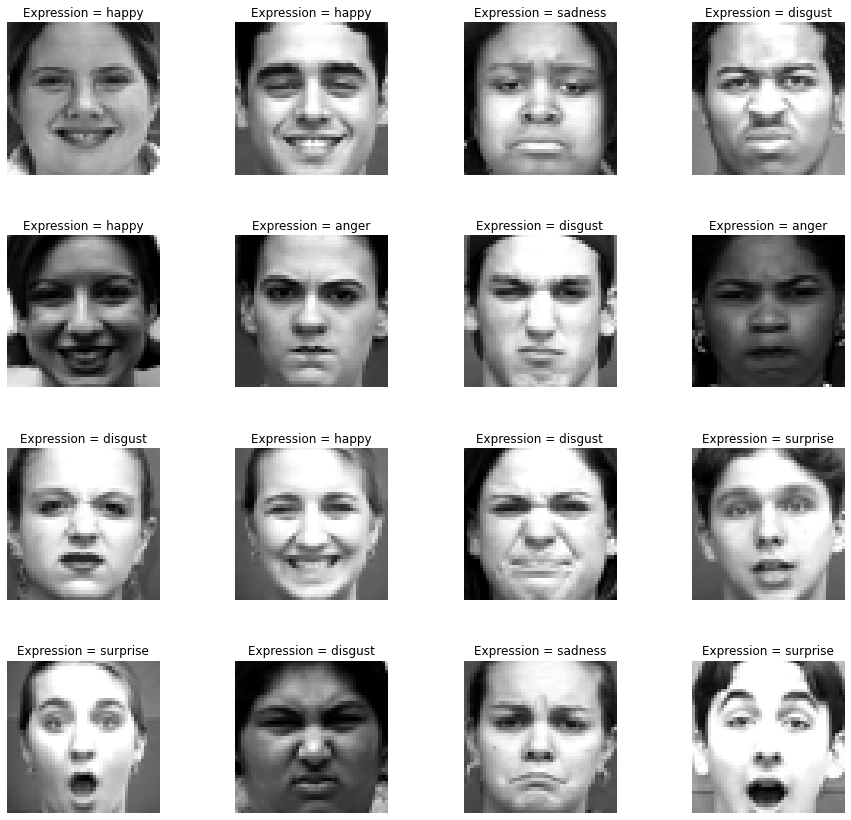

In [23]:
L = 4
W = 4
fig, axes = plt.subplots(L, W, figsize = (15,15))
axes = axes.ravel()

for i in range(0, L * W):  
    sample = random.choice(data)
    axes[i].set_title("Expression = "+str(CATEGORIES[sample[1]]))
    axes[i].imshow(sample[0], cmap='gray')
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

## Data preprocessing

### Creating training and testing data

In [24]:
X = np.array([ x[0] for x in data])
y = np.array([Y[1] for Y in data])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("-------------------------------")
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (784, 48, 48)
y_train shape:  (784,)
-------------------------------
X_test shape:  (197, 48, 48)
y_test shape:  (197,)


In [25]:
# reshaping y_train and y_test
y_train = np.reshape(y_train, (len(y_train),1))
y_test  = np.reshape(y_test , (len(y_test ),1))

print("After reshaping")
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train_Gabor  = X_train
X_test_Gabor = X_test

After reshaping
y_train shape:  (784, 1)
y_test shape:  (197, 1)


### Adding color channel

In [26]:
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)

print("After adding color channel")
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

After adding color channel
X_train shape:  (784, 48, 48, 1)
X_test shape:  (197, 48, 48, 1)


### Normalizing pixel values

In [27]:
X_train = X_train / 255.0
X_test = X_test / 255.0

### Converting single values to category array

In [28]:
y_train[0]

array([6])

In [29]:
y_train_SVM = y_train
y_test_SVM = y_test

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [30]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [31]:
y_train.shape, y_test.shape

((784, 7), (197, 7))

## Feature Extraction

#### HOG Technique

In [32]:
from skimage.transform import resize
from skimage.feature import hog

(-0.5, 47.5, 47.5, -0.5)

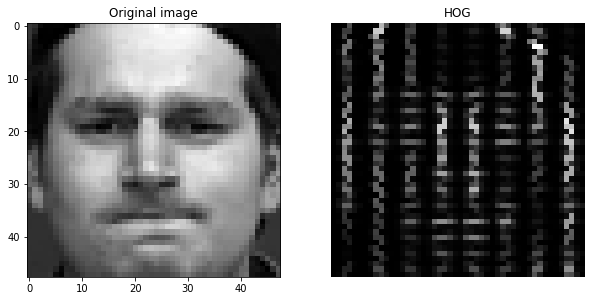

In [37]:
plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
img = random.choice(X_train)
# first image needs to be resized before passing it to HOG descriptor
resized_img =  resize(img, (128, 64))
plt.title("Original image")
plt.imshow(img[:,:,0], cmap='gray')

fd, hog_image = hog(
    resized_img, 
    orientations=9, 
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2), 
    visualize=True, 
    multichannel=True
)
plt.subplot(1,2,2)
plt.title("HOG")
plt.imshow(resize(hog_image, (48, 48)), cmap='gray')
plt.axis('off')

**Creating Feature Vectors for training and testing**

In [38]:
def Create_Hog_features(data):
    Feature_data = np.zeros((len(data),48,48))

    for i in range(len(data)):
        img = data[i]
        resized_img = resize(img, (128, 64))
        fd, hog_image = hog(
            resized_img, 
            orientations=9, 
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2), 
            visualize=True, 
            multichannel=True
        )
        Feature_data[i] = resize(hog_image, (48, 48))
    return Feature_data

In [39]:
Feature_X_train = Create_Hog_features(X_train)
Feature_X_train.shape

(784, 48, 48)

(-0.5, 47.5, 47.5, -0.5)

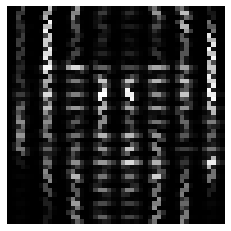

In [40]:
plt.imshow(random.choice(Feature_X_train), cmap='gray')
plt.axis('off')

In [41]:
# doing same for test data 
Feature_X_test = Create_Hog_features(X_test)

Feature_X_test.shape

(197, 48, 48)

(-0.5, 47.5, 47.5, -0.5)

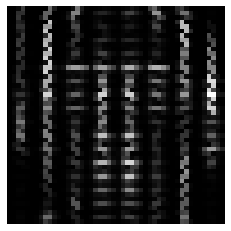

In [42]:
plt.imshow(random.choice(Feature_X_test), cmap='gray')
plt.axis('off')

In [43]:
# Again adding color channel as it got removed while converting img to hog img
X_train_HOG = np.expand_dims(Feature_X_train, axis=3)
X_test_HOG = np.expand_dims(Feature_X_test, axis=3)

print("After adding color channel")
print("X_train_HOG shape: ", X_train_HOG.shape)
print("X_test_HOG shape: ", X_test_HOG.shape)

After adding color channel
X_train_HOG shape:  (784, 48, 48, 1)
X_test_HOG shape:  (197, 48, 48, 1)


In [44]:
print("X_train_HOG shape: ", X_train_HOG.shape)
print("y_train shape: ", y_train.shape)
print("X_test_HOG shape: ", X_test_HOG.shape)
print("y_test shape: ", y_test.shape)

X_train_HOG shape:  (784, 48, 48, 1)
y_train shape:  (784, 7)
X_test_HOG shape:  (197, 48, 48, 1)
y_test shape:  (197, 7)


In [ ]:
# Data Augmentation
# train_datagen = ImageDataGenerator(
#     rotation_range=25, width_shift_range=0.1,
#     height_shift_range=0.1, shear_range=0.2, 
#     zoom_range=0.2,horizontal_flip=True, 
#     fill_mode="nearest"
# )

**Training and Testing the HOG-CNN model**

In [45]:
def create_model(input_shape=None):
    if input_shape is None :
        input_shape=(48,48,1)

    model = Sequential()
    model.add(Conv2D(6, (5, 5), input_shape=input_shape, padding='same', activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(16, (5, 5), padding='same', activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation = 'softmax'))
    
    return model 

In [46]:
es = EarlyStopping(
    monitor='val_accuracy', min_delta=0.0001, patience=10, verbose=2,
    mode='max', baseline=None, restore_best_weights=True
)
lr = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=5, verbose=2,
    mode='max', min_delta=1e-5, cooldown=0, min_lr=0
)

callbacks = [es, lr]

In [47]:
HOG_model = create_model()

In [48]:
HOG_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        9280      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 5, 64)         0

In [49]:
HOG_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam' )

Training the HOG-CNN moel

In [50]:
HOG_history = HOG_model.fit(X_train_HOG, y_train, batch_size=8 , epochs=50, validation_data = (X_test_HOG, y_test), callbacks = [callbacks])

Epoch 1/50
98/98 [==============================] - 9s 7ms/step - loss: 1.8720 - accuracy: 0.2232 - val_loss: 1.8300 - val_accuracy: 0.3249 - lr: 0.0010
Epoch 2/50
98/98 [==============================] - 0s 4ms/step - loss: 1.8404 - accuracy: 0.2487 - val_loss: 1.7357 - val_accuracy: 0.3046 - lr: 0.0010
Epoch 3/50
98/98 [==============================] - 0s 4ms/step - loss: 1.7468 - accuracy: 0.3125 - val_loss: 1.5626 - val_accuracy: 0.4924 - lr: 0.0010
Epoch 4/50
98/98 [==============================] - 0s 4ms/step - loss: 1.4567 - accuracy: 0.4783 - val_loss: 1.1709 - val_accuracy: 0.5635 - lr: 0.0010
Epoch 5/50
98/98 [==============================] - 0s 4ms/step - loss: 1.1798 - accuracy: 0.5599 - val_loss: 0.9508 - val_accuracy: 0.6396 - lr: 0.0010
Epoch 6/50
98/98 [==============================] - 0s 4ms/step - loss: 0.9990 - accuracy: 0.6288 - val_loss: 0.8688 - val_accuracy: 0.6954 - lr: 0.0010
Epoch 7/50
98/98 [==============================] - 0s 4ms/step - loss: 0.8753 - a

After the training process is completed, here is the accuracy diagram of the training and validation accuracy.

In [51]:
def plot_performance(history):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')

    plt.legend()
    plt.grid()
    plt.title('train and val loss evolution')

    plt.subplot(2, 1, 2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')

    plt.legend()
    plt.grid()
    plt.title('train and val accuracy')

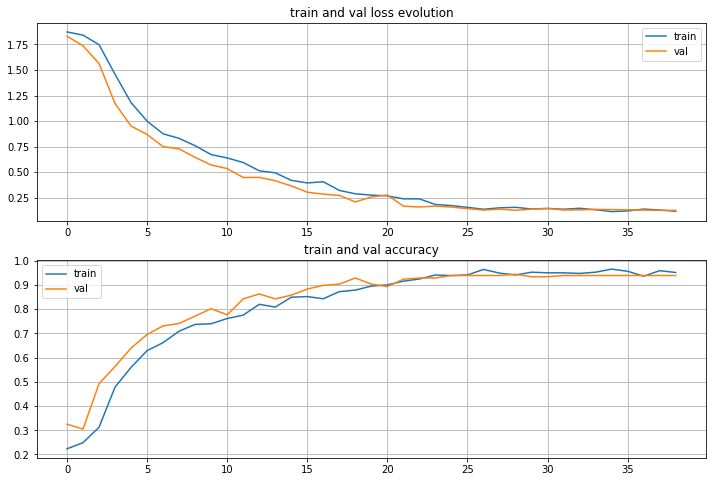

In [52]:
plot_performance(HOG_history)

In [53]:
acc = []
HOG_acc = HOG_model.evaluate(X_test_HOG, y_test, verbose = 0)[1]
acc.append(HOG_acc)
print("HOG Accuracy :",HOG_model.evaluate(X_test_HOG, y_test, verbose = 0)[1])
HOG_model.save('HOG_model.h5')

HOG Accuracy : 0.9441624283790588


#### LBP Technique

In [54]:
def Binarypattern(im):                               # creating function to get local binary pattern
    img= np.zeros_like(im)
    n=3                                              # taking kernel of size 3*3
    for i in range(0,im.shape[0]-n):                 # for image height
        for j in range(0,im.shape[1]-n):               # for image width
            x  = im[i:i+n,j:j+n]                     # reading the entire image in 3*3 format
            center       = x[1,1]                    # taking the center value for 3*3 kernel
            img1        = (x >= center)*1.0          # checking if neighbouring values of center value is greater or less than center value
            img1_vector = img1.T.flatten()           # getting the image pixel values 
            img1_vector = np.delete(img1_vector,4)  
            digit = np.where(img1_vector)[0]         
            if len(digit) >= 1:                     # converting the neighbouring pixels according to center pixel value
                num = np.sum(2**digit)              # if n> center assign 1 and if n<center assign 0
            else:                                    # if 1 then multiply by 2^digit and if 0 then making value 0 and aggregating all the values of kernel to get new center value
                num = 0
            img[i+1,j+1] = num
    return(img)

(-0.5, 47.5, 47.5, -0.5)

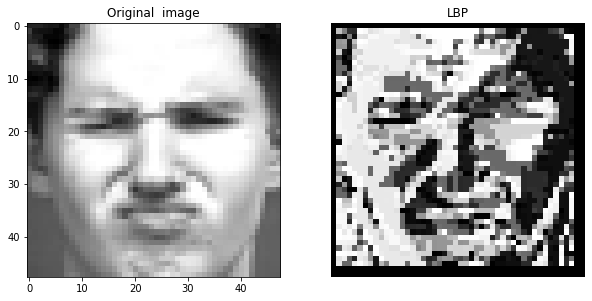

In [57]:
plt.figure(figsize = (10,10))

plt.subplot(1,2,1)
img = random.choice(X_train)
plt.title("Original  image")
plt.imshow(img[:,:,0], cmap='gray')

plt.subplot(1,2,2)
plt.title("LBP")
imgLBP=Binarypattern(img)             # calling the LBP function using gray image
plt.imshow(imgLBP[:,:,0], cmap='gray')
plt.axis('off')

**Creating Feature Vectors for training and testing**

In [58]:
X_train.shape

(784, 48, 48, 1)

In [59]:
def create_LBP_features(data):
    Feature_data = np.zeros(data.shape)

    for i in range(len(data)):
        img = data[i]
        imgLBP=Binarypattern(img)  
        Feature_data[i] = imgLBP
    
    return Feature_data

In [60]:
Feature_X_train = create_LBP_features(X_train)
Feature_X_train.shape

(784, 48, 48, 1)

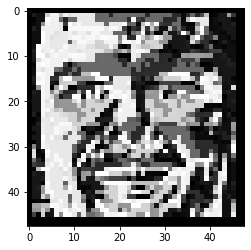

In [62]:
img = random.choice(Feature_X_train)
plt.imshow(img[:,:,0], cmap='gray')

In [63]:
Feature_X_test = create_LBP_features(X_test)
Feature_X_test.shape

(197, 48, 48, 1)

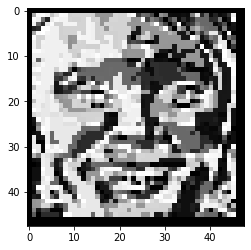

In [65]:
img = random.choice(Feature_X_test)
plt.imshow(img[:,:,0], cmap='gray')

**Training and testing LBP-CNN model**

In [66]:
LBP_model = create_model()
LBP_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam' )

In [67]:
LBP_history = LBP_model.fit(Feature_X_train, y_train, batch_size=8 , epochs=50, validation_data = (Feature_X_test, y_test) ,callbacks = [callbacks])

Epoch 1/50
98/98 [==============================] - 1s 6ms/step - loss: 9.2672 - accuracy: 0.2270 - val_loss: 1.7188 - val_accuracy: 0.3858 - lr: 0.0010
Epoch 2/50
98/98 [==============================] - 0s 4ms/step - loss: 1.7161 - accuracy: 0.3151 - val_loss: 1.4682 - val_accuracy: 0.4518 - lr: 0.0010
Epoch 3/50
98/98 [==============================] - 0s 4ms/step - loss: 1.5085 - accuracy: 0.4247 - val_loss: 1.3011 - val_accuracy: 0.5482 - lr: 0.0010
Epoch 4/50
98/98 [==============================] - 0s 4ms/step - loss: 1.3336 - accuracy: 0.4643 - val_loss: 1.0325 - val_accuracy: 0.6853 - lr: 0.0010
Epoch 5/50
98/98 [==============================] - 0s 5ms/step - loss: 1.1384 - accuracy: 0.5574 - val_loss: 0.8285 - val_accuracy: 0.7817 - lr: 0.0010
Epoch 6/50
98/98 [==============================] - 0s 4ms/step - loss: 0.8549 - accuracy: 0.6658 - val_loss: 0.7043 - val_accuracy: 0.7716 - lr: 0.0010
Epoch 7/50
98/98 [==============================] - 0s 4ms/step - loss: 0.8341 - a

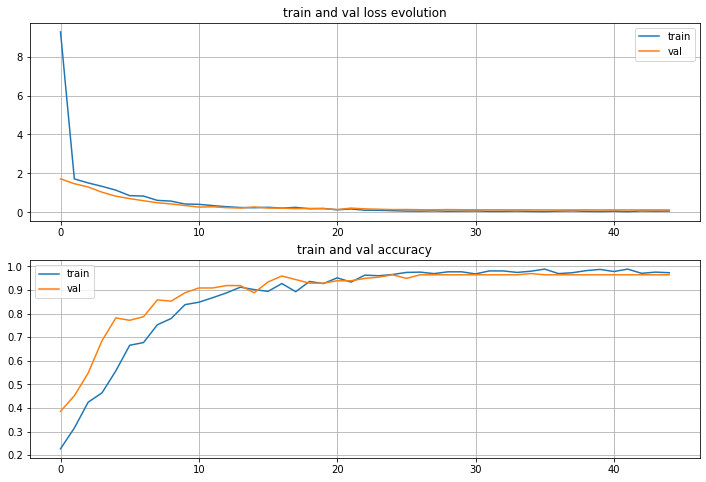

In [68]:
plot_performance(LBP_history)

In [69]:
LBP_acc = LBP_model.evaluate(Feature_X_test, y_test, verbose = 0)[1]
acc.append(LBP_acc)
print("LBP Accuracy :",LBP_model.evaluate(Feature_X_test, y_test, verbose = 0)[1])
LBP_model.save('LBP_model.h5')

LBP Accuracy : 0.9695431590080261


#### SIFT Technique

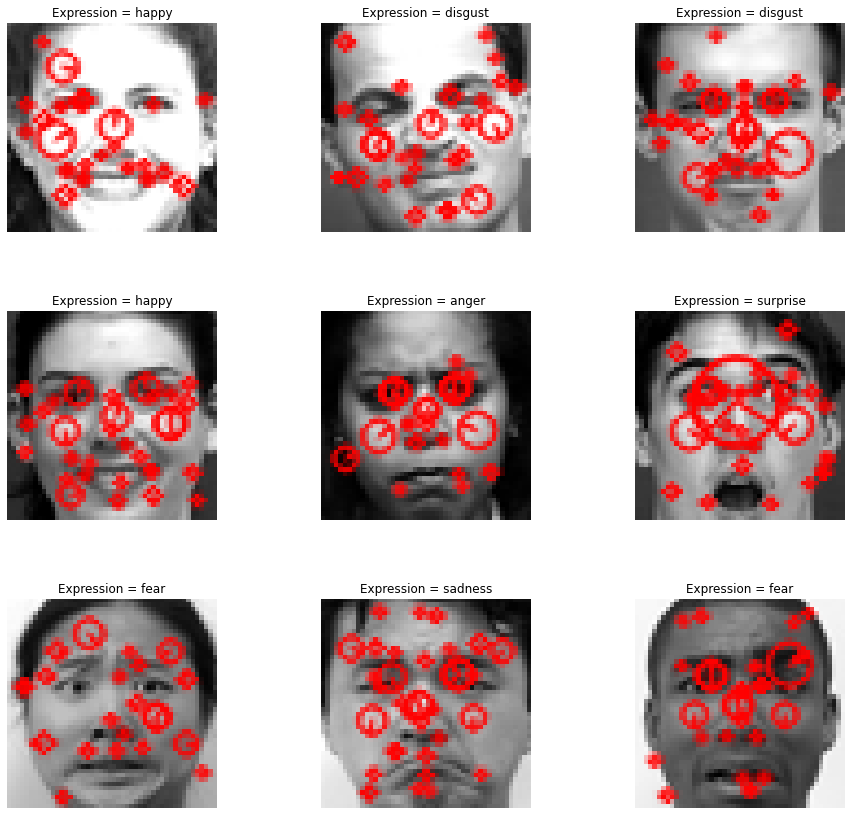

In [70]:
L = 3
W = 3
fig, axes = plt.subplots(L, W, figsize = (15,15))
axes = axes.ravel()

for i in range(0, L * W):  
    sample = random.choice(data)
    image8bit = cv2.normalize(sample[0], None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(image8bit,None)

    img = cv2.drawKeypoints(image=image8bit, outImage=sample[0], keypoints = kp, flags = 4, color = (255, 0, 0))
    axes[i].set_title("Expression = "+str(CATEGORIES[sample[1]]))
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

In [71]:
img.shape

(48, 48, 3)

**Creating Feature Vectors for training and testing**

In [72]:
#so to create a feature vector we will have to create an empty array of shape (len(data), 48,48,3)
def create_SIFT_features(data):
    Feature_data = np.zeros((len(data),48,48,3))

    for i in range(len(data)):
        img = data[i]
        image8bit = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        sift = cv2.SIFT_create()
        kp, des = sift.detectAndCompute(image8bit,None)

        img = cv2.drawKeypoints(image=image8bit, outImage=img, keypoints = kp, flags = 4, color = (255, 0, 0))
        Feature_data[i] = img/255.0

        
    return Feature_data 

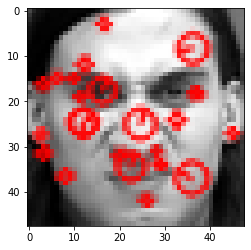

In [73]:
X_train_SIFT = create_SIFT_features(X_train) 
X_train_SIFT.shape
plt.imshow(X_train_SIFT[0], cmap='gray')

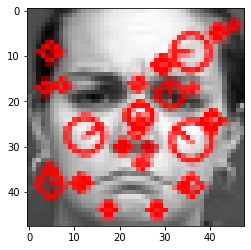

In [74]:
X_test_SIFT = create_SIFT_features(X_test) 
X_test_SIFT.shape
plt.imshow(X_test_SIFT[0], cmap='gray')

**Training and testing SIFT-CNN model**

In [75]:
SIFT_model = create_model(input_shape=(48,48,3))
SIFT_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam' )

In [76]:
SIFT_history = SIFT_model.fit(X_train_SIFT, y_train, batch_size=8 , epochs=50, validation_data = (X_test_SIFT, y_test),  callbacks = [callbacks])

Epoch 1/50
98/98 [==============================] - 1s 7ms/step - loss: 1.8444 - accuracy: 0.2730 - val_loss: 1.6210 - val_accuracy: 0.4365 - lr: 0.0010
Epoch 2/50
98/98 [==============================] - 0s 5ms/step - loss: 1.3357 - accuracy: 0.5128 - val_loss: 1.1383 - val_accuracy: 0.5279 - lr: 0.0010
Epoch 3/50
98/98 [==============================] - 0s 4ms/step - loss: 1.0284 - accuracy: 0.6173 - val_loss: 0.7914 - val_accuracy: 0.6853 - lr: 0.0010
Epoch 4/50
98/98 [==============================] - 0s 5ms/step - loss: 0.7862 - accuracy: 0.7130 - val_loss: 0.6388 - val_accuracy: 0.7411 - lr: 0.0010
Epoch 5/50
98/98 [==============================] - 0s 4ms/step - loss: 0.6323 - accuracy: 0.7832 - val_loss: 0.5571 - val_accuracy: 0.7868 - lr: 0.0010
Epoch 6/50
98/98 [==============================] - 0s 4ms/step - loss: 0.5362 - accuracy: 0.8099 - val_loss: 0.4540 - val_accuracy: 0.8223 - lr: 0.0010
Epoch 7/50
98/98 [==============================] - 0s 4ms/step - loss: 0.4041 - a

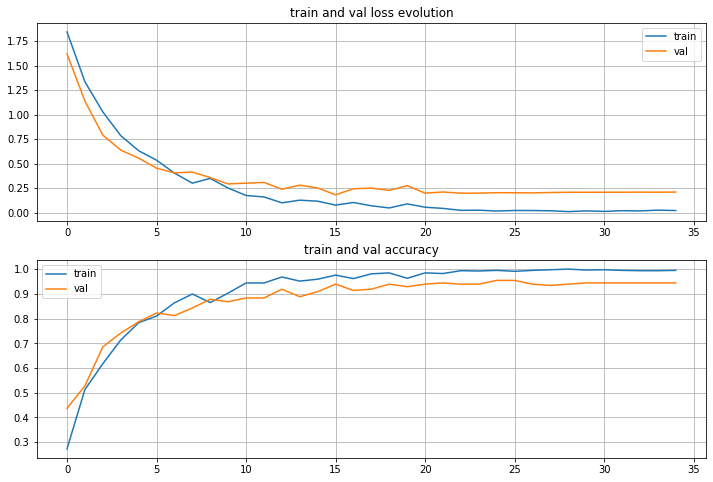

In [77]:
plot_performance(SIFT_history)

In [78]:
SIFT_acc = SIFT_model.evaluate(X_test_SIFT, y_test, verbose = 0)[1]
acc.append(SIFT_acc)
print("SIFT Accuracy :",SIFT_model.evaluate(X_test_SIFT, y_test, verbose = 0)[1])
SIFT_model.save('SIFT_model.h5')

SIFT Accuracy : 0.9543147087097168


#### Gabor Filters

In [79]:
def Gabor_filter(K_size=111, Sigma=10, Gamma=1.2, Lambda=10, Psi=0, angle=0):
    # get half size
    d = K_size // 2

    # prepare kernel
    gabor = np.zeros((K_size, K_size), dtype=np.float32)

    # each value
    for y in range(K_size):
        for x in range(K_size):
            # distance from center
            px = x - d
            py = y - d

            # degree -> radian
            theta = angle / 180. * np.pi

            # get kernel x
            _x = np.cos(theta) * px + np.sin(theta) * py

            # get kernel y
            _y = -np.sin(theta) * px + np.cos(theta) * py

            # fill kernel
            gabor[y, x] = np.exp(-(_x**2 + Gamma**2 * _y**2) / (2 * Sigma**2)) * np.cos(2*np.pi*_x/Lambda + Psi)

    # kernel normalization
    gabor /= np.sum(np.abs(gabor))

    return gabor


# Use Gabor filter to act on the image
def Gabor_filtering(gray, K_size=111, Sigma=10, Gamma=1.2, Lambda=10, Psi=0, angle=0):
    # get shape
    H, W = gray.shape

    # padding
    gray = np.pad(gray, (K_size//2, K_size//2), 'edge')

    # prepare out image
    out = np.zeros((H, W), dtype=np.float32)

    # get gabor filter
    gabor = Gabor_filter(K_size=K_size, Sigma=Sigma, Gamma=Gamma, Lambda=Lambda, Psi=0, angle=angle)

    # filtering
    for y in range(H):
        for x in range(W):
            out[y, x] = np.sum(gray[y : y + K_size, x : x + K_size] * gabor)

    out = np.clip(out, 0, 255)
    out = out.astype(np.uint8)

    return out


# Use 6 Gabor filters with different angles to perform feature extraction on the image
def Gabor_process(img):
#     print(img.shape)
    # get shape
    H, W = img.shape

    # gray scale
#     gray = BGR2GRAY(img).astype(np.float32)

    # define angle
    #As = [0, 45, 90, 135]
    As = [0,30,60,90,120,150]

    # prepare pyplot
#     plt.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0, wspace=0.2)

    out = np.zeros([H, W], dtype=np.float32)

    # each angle
    for i, A in enumerate(As):
    
        # gabor filtering
        _out = Gabor_filtering(img, K_size=11, Sigma=1.5, Gamma=1.2, Lambda=3, angle=A)
         

        # add gabor filtered image
        out += _out
        

    # scale normalization
    out = out /out.max()*255
    out = out.astype(np.uint8)

    return out

In [80]:
def create_Gabor_features(data):
    Feature_data = np.zeros((len(data),48,48,1))

    for i in range(len(data)):
        img = data[i]
        out = Gabor_process(img)
        out = np.expand_dims(out , axis = 2) # adding color channel
        Feature_data[i] = out/255.00

        
    return Feature_data 

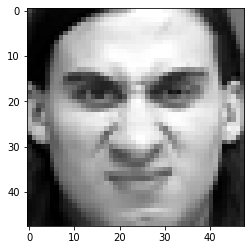

In [81]:
X_train.shape
plt.imshow(X_train_Gabor[0]/255.0, cmap ='gray')

In [82]:
X_train_Gabor=create_Gabor_features(X_train_Gabor)
X_test_Gabor=create_Gabor_features(X_test_Gabor)

X_train_Gabor.shape , X_test_Gabor.shape

((784, 48, 48, 1), (197, 48, 48, 1))

(784, 48, 48, 1)

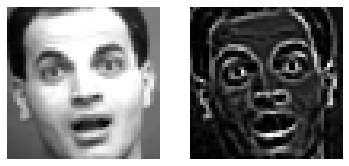

In [84]:
sample = random.randint(100,500)
plt.subplot(1,2,1)
plt.imshow(X_train[sample][:,:,0],cmap='gray')
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(X_train_Gabor[sample][:,:,0],cmap='gray')
plt.axis("off")
X_train_Gabor.shape

**Training and testing Gabor-CNN model**

In [85]:
Gabor_model = create_model()
Gabor_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam' )

In [86]:
Gabor_history = Gabor_model.fit(X_train_Gabor, y_train, batch_size=8 , epochs=50, validation_data = (X_test_Gabor, y_test) ,callbacks = [callbacks])

Epoch 1/50
98/98 [==============================] - 1s 6ms/step - loss: 1.8449 - accuracy: 0.2883 - val_loss: 1.7090 - val_accuracy: 0.4619 - lr: 0.0010
Epoch 2/50
98/98 [==============================] - 0s 4ms/step - loss: 1.5243 - accuracy: 0.4732 - val_loss: 1.1572 - val_accuracy: 0.5990 - lr: 0.0010
Epoch 3/50
98/98 [==============================] - 0s 4ms/step - loss: 1.1127 - accuracy: 0.6339 - val_loss: 0.8951 - val_accuracy: 0.6853 - lr: 0.0010
Epoch 4/50
98/98 [==============================] - 0s 5ms/step - loss: 0.8456 - accuracy: 0.7041 - val_loss: 0.6747 - val_accuracy: 0.7665 - lr: 0.0010
Epoch 5/50
98/98 [==============================] - 0s 4ms/step - loss: 0.6373 - accuracy: 0.7895 - val_loss: 0.5311 - val_accuracy: 0.8325 - lr: 0.0010
Epoch 6/50
98/98 [==============================] - 0s 4ms/step - loss: 0.5144 - accuracy: 0.8278 - val_loss: 0.3691 - val_accuracy: 0.8731 - lr: 0.0010
Epoch 7/50
98/98 [==============================] - 0s 4ms/step - loss: 0.4103 - a

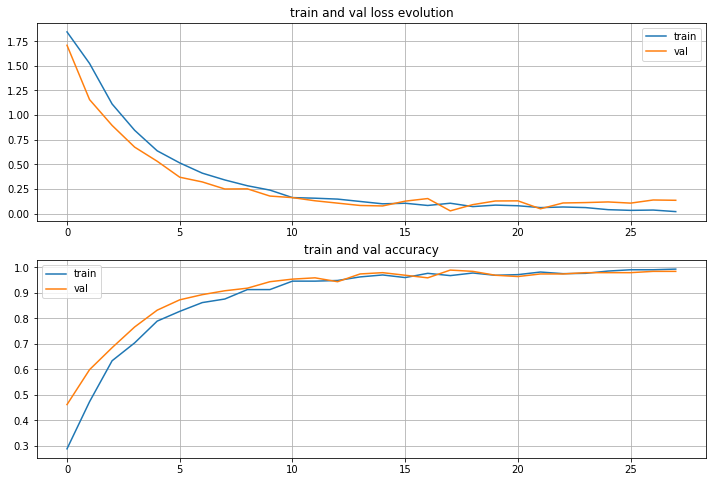

In [87]:
plot_performance(Gabor_history)

In [88]:
Gabor_acc = Gabor_model.evaluate(X_test_Gabor, y_test, verbose = 0)[1]
acc.append(Gabor_acc)
print("Gabor Accuracy :",Gabor_model.evaluate(X_test_Gabor, y_test, verbose = 0)[1])
Gabor_model.save('Gabor_model.h5')

Gabor Accuracy : 0.989847719669342


## Without Feature Extraction

In [89]:
WFE_model = create_model()
WFE_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam' )
WFE_history = WFE_model.fit(X_train, y_train, batch_size=8 , epochs=50, validation_data = (X_test, y_test) ,callbacks = [callbacks])

Epoch 1/50
98/98 [==============================] - 1s 6ms/step - loss: 1.7547 - accuracy: 0.3546 - val_loss: 1.3285 - val_accuracy: 0.6244 - lr: 0.0010
Epoch 2/50
98/98 [==============================] - 0s 4ms/step - loss: 1.1169 - accuracy: 0.5918 - val_loss: 0.7959 - val_accuracy: 0.7513 - lr: 0.0010
Epoch 3/50
98/98 [==============================] - 0s 4ms/step - loss: 0.8176 - accuracy: 0.7105 - val_loss: 0.6182 - val_accuracy: 0.7614 - lr: 0.0010
Epoch 4/50
98/98 [==============================] - 0s 4ms/step - loss: 0.6137 - accuracy: 0.7857 - val_loss: 0.4115 - val_accuracy: 0.8629 - lr: 0.0010
Epoch 5/50
98/98 [==============================] - 0s 4ms/step - loss: 0.4708 - accuracy: 0.8163 - val_loss: 0.3502 - val_accuracy: 0.8680 - lr: 0.0010
Epoch 6/50
98/98 [==============================] - 0s 5ms/step - loss: 0.3539 - accuracy: 0.8737 - val_loss: 0.2416 - val_accuracy: 0.9036 - lr: 0.0010
Epoch 7/50
98/98 [==============================] - 0s 4ms/step - loss: 0.2847 - a

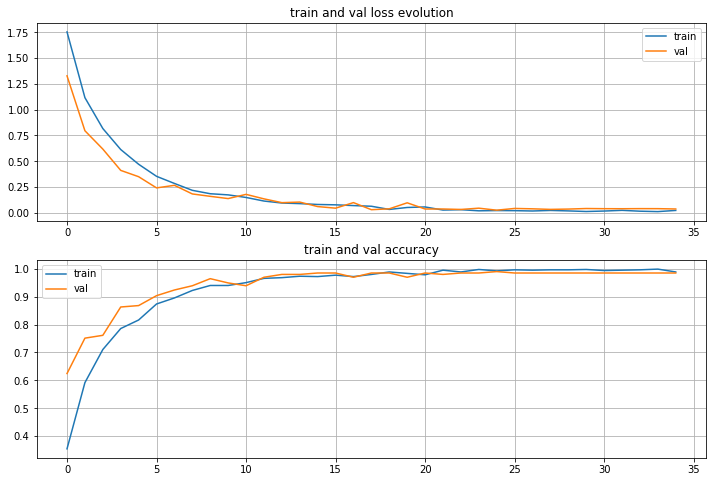

In [91]:
plot_performance(WFE_history)

In [92]:
WFE_acc = WFE_model.evaluate(X_test, y_test, verbose = 0)[1]
acc.append(WFE_acc)
print("Without Feature extraction Accuracy :", WFE_acc)
WFE_model.save('WFE_model.h5')

Without Feature extraction Accuracy : 0.989847719669342


## Comparing accuracies

In [93]:
acc

[0.9441624283790588,
 0.9695431590080261,
 0.9543147087097168,
 0.989847719669342,
 0.989847719669342]

In [94]:
results = pd.DataFrame(acc, index=['HOG', 'LBP', 'SIFT', 'Gabor', 'Without Feature Extraction'], columns = ['Accuracies'])
dfStyler = results.style.set_properties(**{'text-align': 'left'})
dfStyler.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])

,Accuracies
HOG,0.944162
LBP,0.969543
SIFT,0.954315
Gabor,0.989848
Without Feature Extraction,0.989848


So it can be seen that feature extraction with gabor filters are giving pretty good results than the other methods but also it can noted that CNNs witout any feature extraction methods are also giving good results than the other feature extraction techniques such as HOG, LBP, SIFT.